In [1]:
import numpy as np
import time

In [2]:
class Pulse:
    def __init__(self, seq_num=0, detected_time=None, travel_time=0, phase=0, mu_poisson=0.1):
        self.emitted_time = time.time()
        self.detected_time = detected_time
        self.travel_time = travel_time  # Total travel time of the pulse
        self.phase = phase  # Phase of the pulse
        self.photon_number = np.random.poisson(mu_poisson)
        self.detector = None
        self.seq_num = seq_num 

    def __str__(self):
        return f"Pulse(emitted_time={self.emitted_time}, seq_num={self.seq_num}, detected_time={self.detected_time}, travel_time={self.travel_time}, phase={self.phase}, photon number={self.photon_number}, detector:{self.detector})"

    def beam_splitter(self, x_percentage=50, delay=1):
        # Splitting ratio: x_percentage : y  
        if np.random.rand() <= x_percentage / 100:
            self.travel_time += delay  # Pulse takes the longer path
        # Else, the pulse takes the shorter path (no additional travel time)
        
    def phase_modulator(self, phase_to_add):
        self.phase += phase_to_add
        
    def random_detection(self, x_percentage=50):
        if np.random.rand() <= x_percentage / 100:
            self.detect(0)
        else:
            self.detect(1)
    
    def detect(self, detector_n):
        assert detector_n in [0, 1]
        
        if self.photon_number > 0:
            self.detector = detector_n
            self.detected_time = time.time() + 1.0

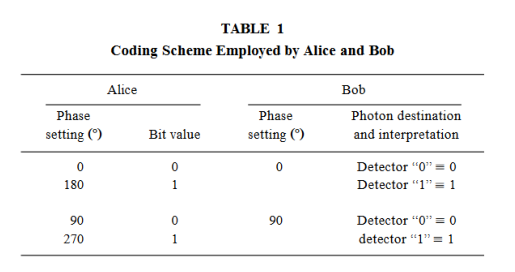

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread(r".\phases_bits.png")

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
def simulate(pulse, phase=0, split_ratio=50):
    pulse.beam_splitter(split_ratio)
    # phase shift applied affects all components of the superposition
    # before we measure the photon, we have to treat it like it went through both arms simultaneously
    pulse.phase_modulator(phase)

def get_bits(phases):
    bits = []
    for phase in phases:
        if phase in [0, np.pi]:
            bits.append(0)
        else:
            bits.append(1)
    return bits

def is_close(value, target, tolerance):
    return abs(value - target) < tolerance

def interference_simulator(pulse, bob_delay):
    tolerance = 0.01  # Define a small tolerance for phase comparisons
    if pulse.travel_time == 1:
        # Interference occurs, detectors click deterministically
        if bob_delay == 0:
            if is_close(pulse.phase, 0, tolerance):
                pulse.detect(0)
            elif is_close(pulse.phase, np.pi, tolerance):
                pulse.detect(1)
        elif is_close(bob_delay, np.pi / 2, tolerance):
            # Add phase to the pulse
            pulse.phase_modulator(np.pi / 2)
            if is_close(pulse.phase, np.pi, tolerance):
                pulse.detect(0)
            elif is_close(pulse.phase, 2 * np.pi, tolerance):
                pulse.detect(1)
    elif pulse.travel_time == 2:
        # Pulse is going second time the long path
        # No interference, detectors click randomly
        pulse.random_detection()
    else:
        # Pulse is going second time the short path
        # No interference, detectors click randomly
        pulse.phase_modulator(bob_delay)
        pulse.random_detection()

def is_close_to_any(value, targets, tolerance):
    """Check if value is within tolerance of any target values."""
    return any(abs(value - target) < tolerance for target in targets)

def generate_bits_and_delays_for_Alice(n=100):
    # Generate an array of n random bits
    bits = np.random.randint(2, size=n)
    delays = []
    for bit in bits:
        if bit == 0:
            delay = np.random.choice([0, np.pi/2])
        else:
            delay = np.random.choice([np.pi, 3*np.pi/2])
        delays.append(delay)
    
    #bases = ['X' if delay in [0, np.pi] else 'Y' for delay in delays]
    # Generate bases with tolerance for phase values
    bases = ['X' if is_close_to_any(delay, [0, np.pi], 0.01) else 'Y' for delay in delays]
    return bits, delays, bases

In [5]:
def compare_alphabets(Alice_bases, Bob_delays):
    # compare which detections were valid and note the count of the pulse
    Bob_bases = ['X' if delay == 0 else 'Y' for delay in Bob_delays]
    shared_bases = []
    shared_seq_nums = []
    
    # Compare Alice and Bob's bases
    for i in range(len(Alice_bases)):
        if Alice_bases[i] == Bob_bases[i]:
            # If the bases match, add the base and sequence number to the respective lists
            shared_bases.append(Alice_bases[i])
            shared_seq_nums.append(i)
    
    return shared_bases, shared_seq_nums
            

def key_sifting(pulses, Alice_bases, Bob_delays):
    # First, find out which pulses have a shared basis and their sequence numbers
    shared_bases, shared_seq_nums = compare_alphabets(Alice_bases, Bob_delays)
    
    # Initialize the sifted key list
    sifted_key = []
    confirmed_seq_nums = []
    
    # Iterate over the shared sequence numbers and bases
    for seq_num, base in zip(shared_seq_nums, shared_bases):
        # Find the corresponding pulse based on sequence number
        # Assuming sequence numbers are 1-indexed and match the order of pulses
        pulse = pulses[seq_num]  # Adjust if seq_nums are 0-indexed
        
        # Check if the pulse was detected and has a valid detector outcome
        if pulse.detector is not None and pulse.travel_time == 1:
            # Determine the bit based on the pulse's detector outcome
            # Assuming the same logic for bit determination as previously
            bit = 0 if pulse.detector == 0 else 1
            sifted_key.append(bit)
            confirmed_seq_nums.append(seq_num)
    
    return sifted_key, confirmed_seq_nums


def alice_sift_key(Alice_original_bits, confirmed_seq_nums):
    """
    Sifts Alice's key based on sequence numbers confirmed by Bob.
    """
    sifted_bits = []
    for seq_num in confirmed_seq_nums:
        sifted_bits.append(Alice_original_bits[seq_num])
    
    return sifted_bits


def compare_random_subset(bits1, bits2, percentage):
    if len(bits1) != len(bits2):
        raise ValueError("The arrays must be of the same length.")
    
    # Calculate the number of bits to compare
    num_bits_to_compare = int(len(bits1) * (percentage / 100.0))
    indices_to_compare = np.random.choice(len(bits1), num_bits_to_compare, replace=False)
    matches = sum(bits1[idx] == bits2[idx] for idx in indices_to_compare)
    match_percentage = (matches / num_bits_to_compare) * 100
    
    return match_percentage, list(indices_to_compare)

def compare_random_subset(bits1, bits2, percentage=25, delete_bits=False, epsilon=0.1):
    bits1 = np.array(bits1)
    bits2 = np.array(bits2)
    if len(bits1) != len(bits2):
        raise ValueError("The arrays must be of the same length.")
    try:
        # Calculate the number of bits to compare
        num_bits_to_compare = int(len(bits1) * (percentage / 100.0))
        indices_to_compare = np.random.choice(len(bits1), num_bits_to_compare, replace=False)
        matches = sum(bits1[idx] == bits2[idx] for idx in indices_to_compare)
        match_percentage = (matches / num_bits_to_compare) * 100
        print(f'Match percentage: {match_percentage} %, Estimated QBER: {match_percentage - 100:.2f} %')

        hoeff = hoeffding_bound(n=num_bits_to_compare, epsilon=epsilon)
        serfling = serfling_bound(N=len(bits1), n=num_bits_to_compare, epsilon=epsilon)
        print(f"Hoeffding's bound = {hoeff:.3f}, Serfling's bound = {serfling:.3f}")

        # If delete_bits is True, remove the compared bits from the original arrays
        if delete_bits:
            indices_not_compared = np.array([idx for idx in range(len(bits1)) if idx not in indices_to_compare])
            # Create new arrays without the compared bits
            reduced_bits1 = bits1[indices_not_compared]
            reduced_bits2 = bits2[indices_not_compared]

            return reduced_bits1, reduced_bits2
        else:
            return bits1, bits2
    except ZeroDivisionError:
        print("Sifted key is too small to perform error estimation")
        return bits1, bits2

Hoeffding’s and Serfling’s Bounds (the probabilities returned by these bounds) represent the upper limits on the probability that the true QBER deviates from your sample estimate by more than the specified epsilon. It's not the probability of error itself but the confidence you can have in your QBER estimation being within epsilon of the true QBER.

In [6]:
def hoeffding_bound(n, epsilon, a=0, b=1):
    """
    Calculates the upper bound on the probability that the sample mean deviates from
    the expected value by more than epsilon using Hoeffding's Inequality.

    Parameters:
    n (int): Number of independent samples = the number of bits to sample and compare between Alice's and Bob's sifted keys to estimate the QBER.
    epsilon (float): Desired precision level.
    a (float): Lower bound of sample values = 0
    b (float): Upper bound of sample values = 1
        since now we have bits 0,1

    Returns upper bound on the deviation probability.
    """
    return np.exp(-2 * n * epsilon**2 / (b - a)**2)

def serfling_bound(N, n, epsilon):
    """
    Calculates the upper bound on the probability that the sample mean deviates from
    the population mean by more than epsilon using Serfling's Inequality.

    Parameters:
    N (int): Population size = is the total number of bits in the sifted key
    n (int): Sample size (without replacement) = number of bits sampled for estimating the QBER.
    epsilon (float): Desired precision level.

    Returns: upper bound on the deviation probability.
    """
    return np.exp(-2 * n * epsilon**2 / (1 - (n - 1) / N))

In [7]:
import hashlib

def generate_key_hash(key_bits):
    """
    Generates a SHA-3 hash of the given key.
    """
    # Convert the list of bits into a byte string
    bit_string = ''.join(str(bit) for bit in key_bits)
    byte_string = int(bit_string, 2).to_bytes((len(bit_string) + 7) // 8, byteorder='big')
    
    # Generate the SHA-3 hash of the byte string
    hash_obj = hashlib.sha3_256(byte_string)
    hash_hex = hash_obj.hexdigest()
    
    return hash_hex

def compare_hashes(Alice_key, Bob_key):
    if generate_key_hash(Alice_key) == generate_key_hash(Bob_key):
        print(f"Hashes of Alice and Bob's key are the same")
        return True
    else:
        return False

def privacy_amplification(bits, final_length_bits=256):
    """
    Applies privacy amplification using the SHA-3 hash function.

    Parameters:
    bits (list of int): The corrected key bits after error correction.
    final_length_bits (int): The desired length of the final key in bits.

    Returns:
    list of int: The final key bits after privacy amplification.
    """
    # Convert the list of bits into a byte string
    bit_string = ''.join(str(bit) for bit in bits)
    byte_string = int(bit_string, 2).to_bytes((len(bit_string) + 7) // 8, byteorder='big')
    
    # Hash the byte string using SHA3-256
    hash_obj = hashlib.sha3_256()
    hash_obj.update(byte_string)
    hashed_bytes = hash_obj.digest()
    
    # Truncate the hashed bytes to the desired final length
    final_byte_length = final_length_bits // 8
    truncated_hashed_bytes = hashed_bytes[:final_byte_length]
    print(f'Final key: {truncated_hashed_bytes}')
    
    # Convert back to bits
    final_key = []
    for byte in truncated_hashed_bytes:
        final_key.extend([int(bit) for bit in bin(byte)[2:].zfill(8)])
    
    return final_key[:final_length_bits]

In [8]:
def simulate_phase_noise(pulse, std_dev=0.05):
    """
    Simulates continuous phase noise by applying a normally distributed random phase shift to each photon's phase.
    The distribution is centered around 0 (mean=0) ==> most likely phase shift is no shift.
    """
    shift = np.random.normal(0, std_dev)
    pulse.phase += shift

def simulate_phase_flip(pulse, phase_flip_probability=0.01):
    """
    Simulates phase-flip errors, where each qubit's phase might be flipped by pi with a given probability.
    """
    flip = np.random.rand() < phase_flip_probability
    if flip:
        if np.random.rand() > 0.5:
            pulse.phase += np.pi
        else:
            pulse.phase -= np.pi


In [12]:
def main():
    # Simulate travel of one pulse
    # generate
    #pulse = Pulse()
    #Alice_delays = np.random.choice([0, np.pi/2, np.pi, 3*np.pi/2], 100)
    #Alice_bits = get_bits(Alice_delays)
    
    num_of_bits_sent = 10000
    all_pulses = []
    # prepare
    Alice_bits, Alice_delays, Alice_basis = generate_bits_and_delays_for_Alice(n=num_of_bits_sent)
    Bob_delays = np.random.choice([0, np.pi/2], num_of_bits_sent)
    
    # experiment simulator
    for i in range(num_of_bits_sent):
        all_pulses.append(Pulse(seq_num=i))
        # Alice
        simulate(all_pulses[i], phase = Alice_delays[i])
        
        # noisy channel
        simulate_phase_noise(all_pulses[i], std_dev=0.05)
        simulate_phase_flip(all_pulses[i], phase_flip_probability=0.001)
        
        # Bob
        # 1) long or short
        all_pulses[i].beam_splitter()
        # 2) interference
        interference_simulator(all_pulses[i], bob_delay = Bob_delays[i])
        
        # if all_pulses[i].detector != None:
            # print(all_pulses[i])

        """ POST PROCESSING """
# get time how long one photon travels... windows has low time precision, so I had to manually add +1 sec to the detection time
    Bob_sifted_key, confirmed_seq_nums = key_sifting(pulses=all_pulses, Alice_bases=Alice_basis, Bob_delays=Bob_delays)
    Alice_sifted_key = alice_sift_key(Alice_bits, confirmed_seq_nums)
    print(Bob_sifted_key)
    print(Alice_sifted_key)
    Alice_final_key, Bob_final_key = compare_random_subset(Alice_sifted_key, Bob_sifted_key, percentage=25, delete_bits=True)
    if Alice_final_key.size > 0:
        compare_hashes(Alice_final_key, Bob_final_key)
        final_shared_key = privacy_amplification(Alice_final_key)

if __name__ == "__main__":
    main()

[1, 1, 1, 0, 1, 0, 1]
[1, 1, 1, 0, 1, 0, 1]
Match percentage: 100.0 %, Estimated QBER: 0.00 %
Hoeffding's bound = 0.980, Serfling's bound = 0.980
Hashes of Alice and Bob's key are the same
Final key: b"\x86\xbcV\xfcV\xafL<\xde\x02\x12\x82\xf6\xb7'\xee\x9f\x90\xddcn\x0b\x0cq*\x85\xd4\x16\xc7^e-"


In [13]:
"""
    TODO:
    - lossy channel
    - basic eavesdropping
    - PNS, decoy states,...
    - statistics: total pulses vs key size etc.
    - QBER maybe doesn't work with noisy phase channel
"""

"\n    TODO:\n    - lossy channel\n    - basic eavesdropping\n    - PNS, decoy states,...\n    - statistics: total pulses vs key size etc.\n    - QBER maybe doesn't work with noisy phase channel\n"

In [26]:
zeros = ones = twos = threes = fours = fives = 0
higher = []

In [27]:
for i in range(10000000):
    gen_pulse = np.random.poisson(0.1)
    if gen_pulse == 0:
        zeros +=1
    elif gen_pulse == 1:
        ones += 1
    elif gen_pulse == 2:
        twos += 1
    elif gen_pulse == 3:
        threes += 1
    elif gen_pulse == 4:
        fours += 1
    elif gen_pulse == 5:
        fives += 1
    else:
        higher.append(gen_pulse)

In [29]:
print(f'zeros: {zeros}')
print(f'ones: {ones}')
print(f'twos: {twos}')
print(f'threes: {threes}')
print(f'fours: {fours}')
print(f'fives: {fives}')

zeros: 9048187
ones: 904972
twos: 45310
threes: 1495
fours: 34
fives: 2


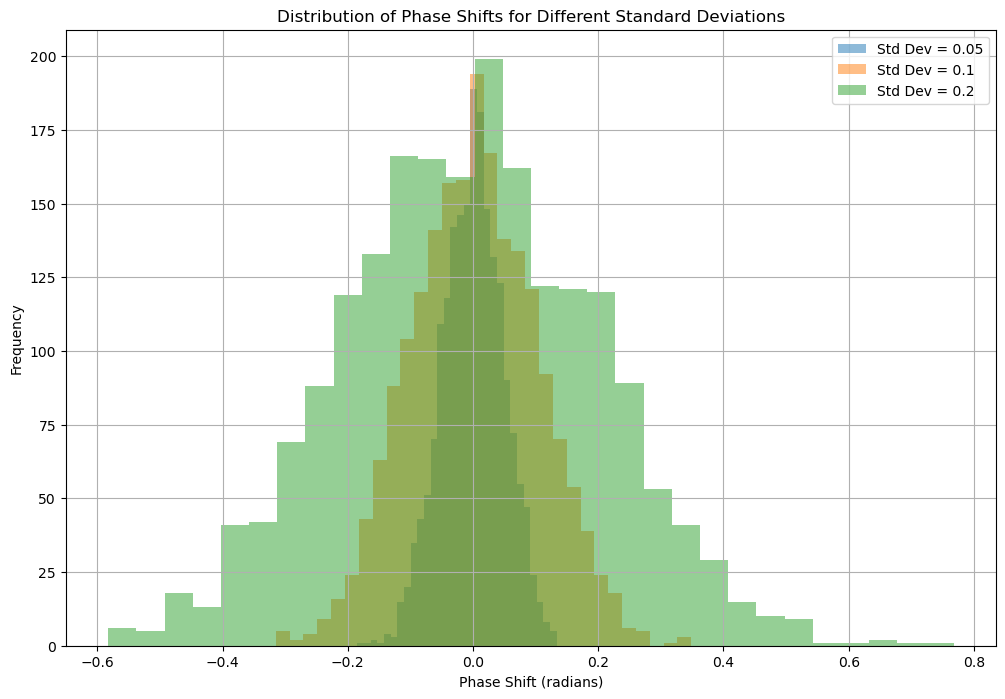

In [14]:
import matplotlib.pyplot as plt

def plot_phase_noise_distribution(std_devs, num_samples=2000):
    plt.figure(figsize=(12, 8))
    for std_dev in std_devs:
        # Generate phase shifts with a mean of 0 and the given standard deviation
        shifts = np.random.normal(0, std_dev, num_samples)
        
        # Plot the histogram of phase shifts
        plt.hist(shifts, bins=30, alpha=0.5, label=f'Std Dev = {std_dev}')

    plt.title('Distribution of Phase Shifts for Different Standard Deviations')
    plt.xlabel('Phase Shift (radians)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_phase_noise_distribution([0.05, 0.1, 0.2])
